# USER RATING PREDICTION USING NLP AND RESTAURANT RECOMMENDATION

## 1. INTRODUCTION

This dataset is a subset of Yelp’s businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp’s data and share their discoveries. In the dataset you’ll find information about businesses across 11 metropolitan areas in four countries.

Before we do any analysis, we have to understand :
1) what information the data has 
2) what relationship exists overall 
3) what can be done with different features. 

We have the following information for Yelp :

- Business - Contains business data including location data, and categories.  
- Attributes - Contains different business attributes
- Reviews - Contains full review text data including the user_id that wrote the review and the business_id the review is written for.  
- User - Conatins user data including the user's friend mapping and all the metadata associated with the user.  
- Checkin - Checkins on a business.  
- Tips - Contains tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.  
- Photos - Contains photo identification related information

In our notebook, we are mainly going to use busniess, user and review data. We are going to deep dive into the reviews of a user, perform text analysis, create a baseline model to predict the sentiment from the review and then compare it with another model where all the text pre-processing is done including removal of stopwords, punctuations and lemmatiation techniques to reflect if there is any significant change iin the sentiment prediction.

Also, we are then going to perform various types of recommendations based on the user ratings. We will first create a BaselineOnly model and then move ahead with various other modelling techniques for recommendations.

## 2. DATA PREPARATION - PACKAGE INSTALLATIONS, GOOGLE AUTHENTICATION, IMPORTING AND LOADING LIBRARIES AND DATA 

In [0]:
!pip install PyDrive

In [0]:
!pip install wordcloud

In [0]:
!pip install surprise

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import time
import nltk

In [0]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> D

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

True

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
%%time
download = drive.CreateFile({'id': '1kU2JyKj_oLg1X_dGH-K3pTOQ_p-Dankx'})
download.GetContentFile('yelp.tar')

CPU times: user 6.77 s, sys: 14.9 s, total: 21.7 s
Wall time: 36.7 s


In [0]:
ls

business.csv  checkin.csv  photos.csv  review.csv  tip.csv  user.csv  yelp.tar


In [0]:
%%time
import zipfile
with zipfile.ZipFile("yelp.tar","r") as zip_ref:
  print('extracting zip file')
  zip_ref.extractall("targetdir")

extracting zip file
CPU times: user 48.5 s, sys: 8.77 s, total: 57.3 s
Wall time: 1min 8s


In [0]:
ls

business.csv  photos.csv  targetdir/  user.csv
checkin.csv   review.csv  tip.csv     yelp.tar


In [0]:
cd targetdir

/content/targetdir/targetdir


In [0]:
ls

business.csv  checkin.csv  photos.csv  review.csv  tip.csv  user.csv


In [2]:
%%time
# basic imports
import pandas as pd
import os, sys
import math
import itertools
import datetime
import time
import gc
import numpy as np
from math import sqrt
import string
import warnings
warnings.filterwarnings('ignore')

#imports for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
import networkx as nx
from wordcloud import WordCloud

# importing libraries for NLP
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

#importing libraries for modelling
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

#importing libraries for recommendations
from surprise import SVD, SVDpp, Dataset, accuracy, Reader, BaselineOnly, KNNBaseline, print_perf, evaluate
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

#importing pickle library
import pickle


Wall time: 1min 54s


In [3]:
# reading only 1,00,000 rows of all csv files due to limited GPU
#%%time
user = pd.read_csv('yelp_data\\user_reduced.csv')
business = pd.read_csv('yelp_data\\business_reduced.csv')
checkin = pd.read_csv('yelp_data\\checkin_reduced.csv')
tip = pd.read_csv('yelp_data\\tip_reduced.csv')
review = pd.read_csv('yelp_data\\review_reduced.csv')

## 4. SENTIMENT ANALYSIS AND PREDICTION USING NAIVE BIAS ALGORITHM

The idea is to create a **baseline model** where we just pick the review text and remove the punctuations only and try to predict the rating on the review by using Naive Bias Algorithm. We then do all the text-preprocessing which involves removal of stopwords, applying lemmatization and bagOfWords technique to the reviews and then try to predict the rating again. The **aim is to compare and analyse** whether doing all the text preprocessing has an impact on the prediction or not. If so, how significant is the imapct on the reveiws. This is been **evaluated by** looking at the **confusion matrix** and **classification report consisting of precision, recall and f1-score**.

### 4.1 TEXT ANALYSIS OF REVIEW TEXT

In [0]:
# Let us look at the word count in the review text
review['word_count'] = review['text'].apply(lambda x: len(str(x).split(" ")))
review[['text','word_count']].head()

,text,word_count
0,"Love the staff, love the meat, love the place....",56
1,Super simple place but amazing nonetheless. It...,35
2,Small unassuming place that changes their menu...,91
3,Lester's is located in a beautiful neighborhoo...,67
4,Love coming here. Yes the place always needs t...,102


In [0]:
# Let us look at the character count in the review text
review['char_count'] = review['text'].str.len() ## this also includes spaces
review[['text','char_count']].head()

,text,char_count
0,"Love the staff, love the meat, love the place....",289
1,Super simple place but amazing nonetheless. It...,213
2,Small unassuming place that changes their menu...,502
3,Lester's is located in a beautiful neighborhoo...,373
4,Love coming here. Yes the place always needs t...,523


In [124]:
# Let us look at the average word length in the review text sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

review['avg_word'] = review['text'].apply(lambda x: avg_word(x))
review[['text','avg_word']].head()
review['text'][1]

"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly."

In [0]:
# Let us look if there is any text that starts with hashtags
review['hashtags'] = review['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
review[['text','hashtags']].head()

,text,hashtags
0,"Love the staff, love the meat, love the place....",0
1,Super simple place but amazing nonetheless. It...,0
2,Small unassuming place that changes their menu...,0
3,Lester's is located in a beautiful neighborhoo...,0
4,Love coming here. Yes the place always needs t...,0


In [0]:
# Let us look at the count of stopwords present in the review text
stop = stopwords.words('english')

review['stopwords'] = review['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
review[['text','stopwords']].head()

,text,stopwords
0,"Love the staff, love the meat, love the place....",18
1,Super simple place but amazing nonetheless. It...,14
2,Small unassuming place that changes their menu...,37
3,Lester's is located in a beautiful neighborhoo...,31
4,Love coming here. Yes the place always needs t...,45


In [0]:
# Let us look at the count of numerics present in the review text
review['numerics'] = review['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
review[['text','numerics']].head()

,text,numerics
0,"Love the staff, love the meat, love the place....",0
1,Super simple place but amazing nonetheless. It...,0
2,Small unassuming place that changes their menu...,2
3,Lester's is located in a beautiful neighborhoo...,1
4,Love coming here. Yes the place always needs t...,2


In [0]:
# Let us look at the top 10 frequent words
freq_top = pd.Series(' '.join(review['text']).split()).value_counts()[:10]
freq_top

the    457755
and    374596
I      290940
a      278603
to     267429
was    192743
of     160037
is     134417
for    126008
in     116542
dtype: int64

In [0]:
# Let us look at the least 10 frequent words
freq_least = pd.Series(' '.join(review['text']).split()).value_counts()[-10:]
freq_least

run"),         1
(range         1
Portugal       1
boba/soda      1
est.           1
Eeesh.         1
company....    1
Iived          1
burata,        1
font)          1
dtype: int64

In [0]:
# Let us include the text length column in review dataset
review['text length'] = review['text'].apply(len)
review.head()

,funny,user_id,review_id,text,business_id,stars,date,useful,cool,year,month,word_count,char_count,avg_word,hashtags,stopwords,numerics,text length
0,0,bv2nCi5Qv5vroFiqKGopiw,v0i_UHJMo_hPBq9bxWvW4w,"Love the staff, love the meat, love the place....",0W4lkclzZThpx3V65bVgig,5,2016-05-28,0,0,2016,5,56,289,4.107143,0,18,0,289
1,0,bv2nCi5Qv5vroFiqKGopiw,vkVSCC7xljjrAI4UGfnKEQ,Super simple place but amazing nonetheless. It...,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,0,0,2016,5,35,213,5.057143,0,14,0,213
2,0,bv2nCi5Qv5vroFiqKGopiw,n6QzIUObkYshz4dz2QRJTw,Small unassuming place that changes their menu...,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,0,0,2016,5,91,502,4.483516,0,37,2,502
3,0,bv2nCi5Qv5vroFiqKGopiw,MV3CcKScW05u5LVfF6ok0g,Lester's is located in a beautiful neighborhoo...,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,0,0,2016,5,67,373,4.552239,0,31,1,373
4,0,bv2nCi5Qv5vroFiqKGopiw,IXvOzsEMYtiJI0CARmj77Q,Love coming here. Yes the place always needs t...,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,0,0,2016,5,102,523,4.138614,0,45,2,523


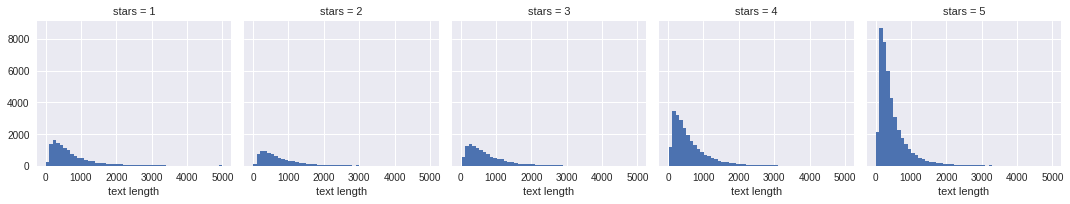

In [0]:
# Lets visualise the review text and stars for a business
g = sns.FacetGrid(data=review, col='stars')
g.map(plt.hist, 'text length', bins=50)

### 4.2 BASELINE MODEL AND PREDICTION USING NAIVE BIAS ALGORITHM

In this model, we take into consideration the review text where we only remove the punctuations in the text and perform text analysis to predict the user ratings on the basis of review text using Naive Bias algorithm. The result is evaluated by the confusion matrix and classification report consisting of recall, precision and f1-score.

In [5]:
# separating our features and target
X = review['text']
y = review['stars']

In [6]:
# function to remove only punctuations from the review text
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Removes all punctuation
    2. Return the text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split()]

In [7]:
# Let us test if the above function worked correctly!
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."

print(text_process(sample_text))

['Hey', 'there', 'This', 'is', 'a', 'sample', 'review', 'which', 'happens', 'to', 'contain', 'punctuations']


In [9]:
# creating a bag of words which consist of entire text without punctuations and fiting it
bow_transformer = CountVectorizer().fit(X)

In [10]:
# Looking for the count of features
len(bow_transformer.vocabulary_)

88257

In [12]:
# Let us now transform our review text
#%%time
X = bow_transformer.transform(X)

In [13]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (100000, 88257)
Amount of Non-Zero occurrences:  7216964
Density: 0.08177214271955766


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (70000, 88257)
Number transactions y_train dataset:  (70000,)
Number transactions X_test dataset:  (30000, 88257)
Number transactions y_test dataset:  (30000,)


In [15]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

Before OverSampling, counts of label '1': 9326
Before OverSampling, counts of label '2': 5811
Before OverSampling, counts of label '3': 8262
Before OverSampling, counts of label '4': 16765
Before OverSampling, counts of label '5': 29836 

After OverSampling, the shape of train_X: (149180, 88257)
After OverSampling, the shape of train_y: (149180,) 

After OverSampling, counts of label '1': 29836
After OverSampling, counts of label '2': 29836
After OverSampling, counts of label '3': 29836
After OverSampling, counts of label '4': 29836
After OverSampling, counts of label '5': 29836


In [16]:
# Let us now train the model using Multinomial Naive Bais Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [121]:
finalized_model = open("Finalized_Model_NB.pkl", "wb")
pickle.dump(nb, finalized_model)

In [17]:
# Let us now predict on the test set
preds = nb.predict(X_test)

In [18]:
# Let us now evaluate our model using confusion matrix and classification report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
print(metrics.accuracy_score(y_test, preds))

[[2941  478  234  167  121]
 [ 693  493  701  486  125]
 [ 342  196  865 1842  300]
 [ 239  100  352 4560 1881]
 [ 538   84  106 3199 8957]]


              precision    recall  f1-score   support

           1       0.62      0.75      0.68      3941
           2       0.36      0.20      0.26      2498
           3       0.38      0.24      0.30      3545
           4       0.44      0.64      0.52      7132
           5       0.79      0.70      0.74     12884

   micro avg       0.59      0.59      0.59     30000
   macro avg       0.52      0.50      0.50     30000
weighted avg       0.60      0.59      0.59     30000

0.5938666666666667


**Observation :**

1. From above, we observe that the misclassification rate is quite high for each of the ratings. It is still better for 1 star and 5 star ratings.

2. 2 star rating has a higher misclassified rating as compared to its true positives where it wrongly predicts it as a 1 star rating majority of the times.

3. 3 star rating also has high misclassification rate where there is almost equal number of chances that it wrongly predicts the rating as a 2 star rating.

4. Looking at the precision and recall for each of the ratings, we see that it is least for 2 star rating. The values for 3 star and 4 star ratings are also not very good which signifies that the model is not good and there is a higher probablity that it will wrongly predict the ratings.

Let us look at some of the examples below -

#### Predicting positive reviews :

In [19]:
review.tail()

,funny,user_id,review_id,text,business_id,stars,date,useful,cool
99995,1,CKRfBUqQGaVCYTKN5kDrzw,RpT1GVVIYC5NZQmsCnUS8Q,Amazing warm waffles at a very reasonable pric...,SThmy10YhS13oFgT990Xhw,5,2013-12-28,2,2
99996,0,CKRfBUqQGaVCYTKN5kDrzw,piG9b34Bk0ptQduZ12LB5g,Cool boutique with clever gifts from local ven...,jAzhMXlm1lg388k-xlANKA,4,2016-11-12,0,0
99997,0,CKRfBUqQGaVCYTKN5kDrzw,UM9Xf3ExrVIfK0a4DbtSVA,Loved the Korean BBQ special sandwich with cil...,dHUb949NckE2GqtlSVlWQg,5,2013-03-04,1,1
99998,0,CKRfBUqQGaVCYTKN5kDrzw,LsGy4-yDOfxJJuvkoIaNkA,Fabulous pub style food and tasty cocktails!\n...,bcTwvbD5wfMSgSO-YczLYw,5,2015-08-11,0,1
99999,0,CKRfBUqQGaVCYTKN5kDrzw,JMHSEhNN42SiM3mVhUzc9A,I had the Santorini breakfast crepe with olive...,zr8Ojsm-yNhvfTzBzcKU9w,3,2016-02-27,0,0


In [52]:
from random import randint
def predict_review(n,bow_transformer,nb,review):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = nb.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review.columns)
    check_df.loc[0] = review.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df

In [56]:
predict_review(55,bow_transformer,nb,review)

The row that has been selected is 36


,funny,user_id,review_id,text,business_id,stars,date,useful,cool,Predicted
0,0,u0LXt3Uea_GidxRW1xcsfg,b1Volwlw8gt_IGh9PhRQmw,This review is mainly for the pool only.\n\nLo...,N-11FCEppz5NVYZVM2G5yA,5,2016-02-08,0,0,5


Thus, we see that the actual rating was 5 for the reveiw and our model very well predicted that rating. Let us now test for another positive reveiw.

Now, let us now try to create another model where we remove all the stopwords and perform lemmatisation and other text processing. We will then try to predict the ratings using Naive Baised Model and test for our predictions.

### 4.3 ADVANCE MODEL AFTER REMOVAL OF STOPWORDS AND OTHER PRE-PROCESSING TECHNIQUE TO PREDICT RATINGS USING NAIVE BIAS AND LOGISTIC REGRESSION ALGORITHM

In [57]:
# function to segregate the Part Of Speech in the review text
# n - noun, v - verb, a - adverb, r - adverb
from nltk.corpus import wordnet
from collections import Counter
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(4)
    return most_common_pos_list[0][0]

In [58]:
# function to perform text preprocessing on the review text
def preprocessing(text):
    
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # lower capitalization
    tokens = [word.lower() for word in tokens]
    
    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    
    # remove punctuations
    tokens = [char for char in tokens if char not in string.punctuation]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(x, get_pos(x)) for x in tokens]
    #tokens = [lmtzr.lemmatize(word, pos='v') for word in tokens]
    preprocessed_text= ' '.join(tokens)

    return preprocessed_text

In [61]:
# sample text to check if the above function worked
sample_text = "Hey there! There are many cats running but I like just I cat!! This is a sample reviews, which happens to contain punctuations."

print(preprocessing(sample_text))

hey many cat run like cat sample review happen contain punctuation


In [0]:
#text = "Hey there There are many cats running but I like just I cat!! This is a sample reviews which happens to contain punctuations"
#txt = nltk.word_tokenize(text)
#nopunc_pos = nltk.pos_tag(txt,tagset='universal')
#print(nopunc_pos)
#nopunc = [lmtzr.lemmatize(x[0], x[1][0].lower()) for x in nopunc_pos]
#nopunc

In [62]:
# separating our features and target 
X = review['text']
y = review['stars']

In [63]:
# creating a bag of words which consist of entire preprocessed review text and fiting it
#%%time
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=preprocessing).fit(X)

In [64]:
# Looking at the count of features in the model
len(bow_transformer.vocabulary_)

865

In [65]:
# Transforming our features in the model
#%%time
X = bow_transformer.transform(X)

In [66]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (100000, 865)
Amount of Non-Zero occurrences:  2656591
Density: 3.0712034682080924


In [67]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (70000, 865)
Number transactions y_train dataset:  (70000,)
Number transactions X_test dataset:  (30000, 865)
Number transactions y_test dataset:  (30000,)


In [68]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))

Before OverSampling, counts of label '1': 9326
Before OverSampling, counts of label '2': 5811
Before OverSampling, counts of label '3': 8262
Before OverSampling, counts of label '4': 16765
Before OverSampling, counts of label '5': 29836 

After OverSampling, the shape of train_X: (149180, 865)
After OverSampling, the shape of train_y: (149180,) 

After OverSampling, counts of label '1': 29836
After OverSampling, counts of label '2': 29836
After OverSampling, counts of label '3': 29836
After OverSampling, counts of label '4': 29836
After OverSampling, counts of label '5': 29836


In [69]:
# Let us now train our model using Multinomial Naive Bais Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
# Predict on the test set
preds = nb.predict(X_test)

In [71]:
# Performance evaluation by confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))
print(metrics.accuracy_score(y_test, preds))

[[ 1544   194    46   234  1923]
 [  628   169    58   300  1343]
 [  578   215   141   588  2023]
 [  723   273   163  1109  4864]
 [ 1108   310   116   907 10443]]


              precision    recall  f1-score   support

           1       0.34      0.39      0.36      3941
           2       0.15      0.07      0.09      2498
           3       0.27      0.04      0.07      3545
           4       0.35      0.16      0.22      7132
           5       0.51      0.81      0.62     12884

   micro avg       0.45      0.45      0.45     30000
   macro avg       0.32      0.29      0.27     30000
weighted avg       0.39      0.45      0.38     30000

0.4468666666666667


Observation :

From above, we observe that the misclassification rate is still high for each of the ratings. 2 star rating is poorly predicted whereas a 5 star rating as much better prediction results compared to other ratings. 

2 star rating has a higher misclassified rating as compared to its true positives where it wrongly predicts it as a 5 star rating majority of the times.

3 star rating also has high misclassification rate where there is almost equal number of chances that it wrongly predicts the rating as a 5 star rating.

Looking at the precision, recall and f1-score for each of the ratings, we see that it is least for 3 star rating. The values for 2 star and 4 star ratings are also not very good which signifies that the model is not good and there is a higher probablity that it will wrongly predict the ratings.

Also, in comparison to the baseline model we observe that this model under-performed after performing text preprocessing. The reason behind high misclassification rate while our modelling is due to the biased nature of reveiws and stars given by the users. As we had seen above while performing the exploratory data analysis, majority of the users have given more than 3 star rating to the business which is why our model turned bias towards positive reviews and predicts ratings which is more than 3 for most of the scenarios.

Let us look at some of the examples below -

#### Predicting positive reviews

In [72]:
from random import randint
def predict_review(n,bow_transformer,nb,review):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = review['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = nb.predict(review_verdict_transformed)[0]
    check_df = pd.DataFrame(columns=review.columns)
    check_df.loc[0] = review.iloc[value]
    check_df['Predicted'] = predicted_rating
    return check_df

In [73]:
predict_review(100,bow_transformer,nb,review)

The row that has been selected is 57


,funny,user_id,review_id,text,business_id,stars,date,useful,cool,Predicted
0,0,u0LXt3Uea_GidxRW1xcsfg,6HHuaN9i-MEYRz4sPRcZEw,Long line ups for Sunday brunch - but so worth...,SCklYa_jhihWAcfIn-_chg,4,2010-03-31,0,0,5


From above we see that the actual rating was 2 and our model misclassified it as a 5 star rating for the business. 

Let us now try it out by using Logistic Regression Model and look if we get better results.

### LOGISTIC REGRESSION TECHNIQUE FOR USER RATING PREDICTION

In [74]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.2, dual=True)
model = model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.44813333333333333


C:\Users\chels\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [75]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

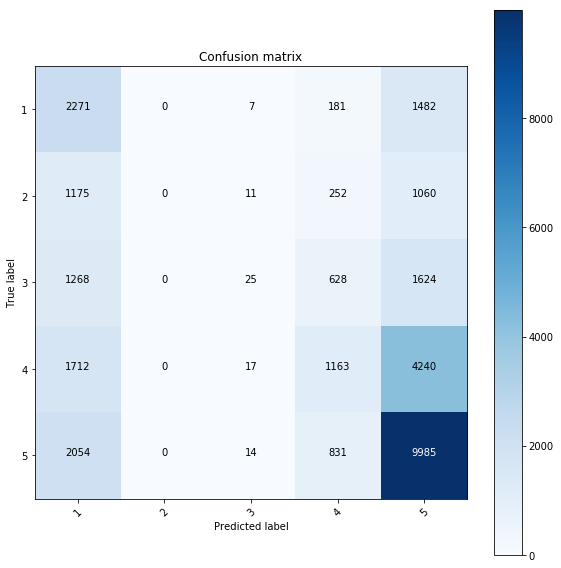

In [76]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['1', '2','3','4','5'], title='Confusion matrix')

In [77]:
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.27      0.58      0.37      3941
           2       0.00      0.00      0.00      2498
           3       0.34      0.01      0.01      3545
           4       0.38      0.16      0.23      7132
           5       0.54      0.77      0.64     12884

   micro avg       0.45      0.45      0.45     30000
   macro avg       0.31      0.30      0.25     30000
weighted avg       0.40      0.45      0.38     30000



C:\Users\chels\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\chels\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\chels\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



From above, we see that the f1-score for 1, 4 and 5 star rating improved slightly as compared to the Naive Bias Model but decreased for 2 and 3 star ratings.

## 5. RECOMENDATION SYSTEM BASED ON USER RATING PREDICTION FOR DIFFERENT MODELS

Here we take into consideration only food related businesses for implementing recommendation systems in order to predict the user ratings.

In [78]:
# taking only those businesses which contain 'Food' as a category 
# And then merging it with review on business_id and user dataset on user_id
business['categories'] = business['categories'].astype(str)
restaurant_df = business[business['categories'].str.contains('Food')==True]
complete_df = restaurant_df.merge(review,on='business_id').merge(user,on='user_id')

In [0]:
# let us look into the complete_df
complete_df.head()

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.HairSpecializesIn.coloring,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,hours.Friday,...,compliment_writer,compliment_cute,average_stars,compliment_more,friends,compliment_hot,cool_y,name_y,compliment_profile,compliment_cool
0,NaN,False,NaN,L4C 9V4,11:30-22:00,NaN,NaN,NaN,NaN,11:30-23:00,...,0,0,3.00,0,"[u'P29oqHWxMa9qMT25z2hDig', u'QZOlthTiwV2SO79f...",1,0,Kay,0,1
1,NaN,False,False,L3T 0A2,11:00-1:00,NaN,NaN,NaN,NaN,11:00-3:00,...,0,0,3.00,0,"[u'P29oqHWxMa9qMT25z2hDig', u'QZOlthTiwV2SO79f...",1,0,Kay,0,1
2,NaN,False,NaN,L4C 9V4,11:30-22:00,NaN,NaN,NaN,NaN,11:30-23:00,...,9,1,3.76,2,"[u'JesJ-LaNfr3pKhL7gWhDrw', u'xttaWX-oTAK3fMoT...",6,11,Andrea,0,7
3,NaN,False,NaN,L3T 7Y3,10:00-19:00,NaN,NaN,NaN,NaN,10:00-19:00,...,9,1,3.76,2,"[u'JesJ-LaNfr3pKhL7gWhDrw', u'xttaWX-oTAK3fMoT...",6,11,Andrea,0,7
4,NaN,False,NaN,M5G 1M5,8:00-23:00,NaN,NaN,NaN,NaN,8:00-23:00,...,9,1,3.76,2,"[u'JesJ-LaNfr3pKhL7gWhDrw', u'xttaWX-oTAK3fMoT...",6,11,Andrea,0,7


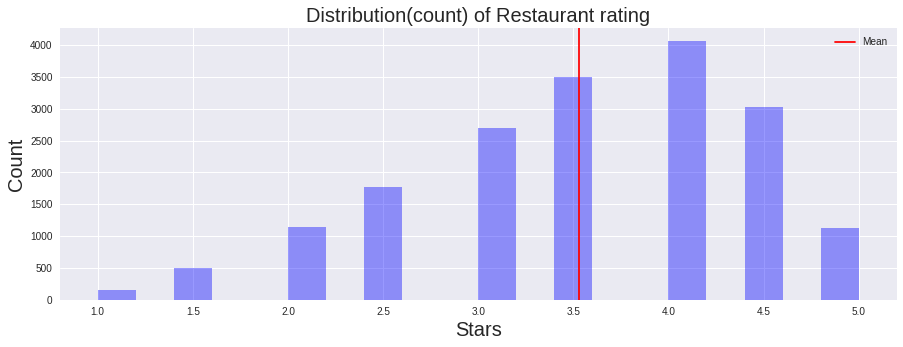

In [0]:
# Distribution count of the restaurent rating !!
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.distplot(restaurant_df.stars,kde=False,color = 'b',ax =ax,bins=20);
ax.axvline(restaurant_df.stars.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of Restaurant rating',size=20);

From above we see that most of the businesses have got 4 star ratinga nd an average of over 3.5 rating.

Text(0.5,1,'Distribution(count) of different Reviews rating')

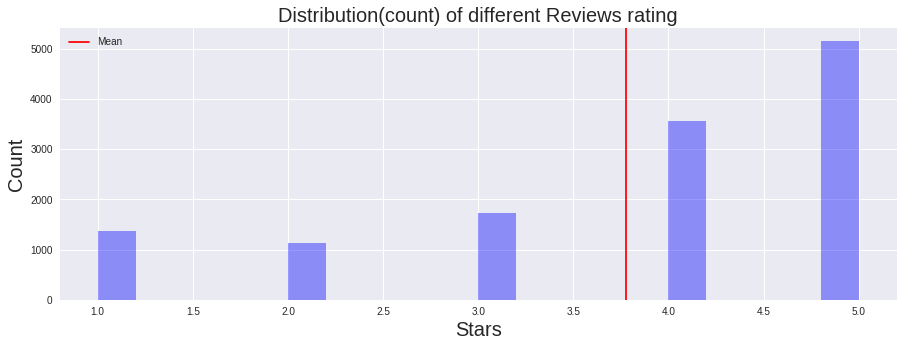

In [0]:
# Distribution count of review ratings !!
#review just for business which are restautrant
review_df_filter_df = review.merge(restaurant_df,how='inner',on='business_id')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(review_df_filter_df.stars_x,kde=False,color = 'b',ax =ax,bins=20);
ax.axvline(review_df_filter_df.stars_x.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of different Reviews rating',size=20)

From above  we see that most of the reviews have got 5 star rating and and average of about 3.8 rating.

Text(0.5,1,'Distribution(count) of User given rating')

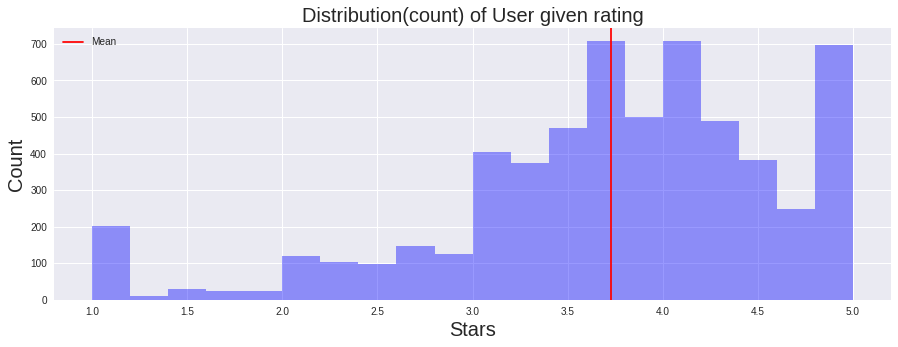

In [0]:
# Distribution count of user ratings just for the business which are restaurent !!
user_df_filter_df = complete_df.groupby(['user_id'],as_index=False).mean()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.distplot(user_df_filter_df.average_stars,kde=False,color = 'b',ax =ax,bins=20);
ax.axvline(user_df_filter_df.average_stars.mean(), 0, 1, color='r', label='Mean')
ax.legend();
ax.set_ylabel('Count',size=20)
ax.set_xlabel('Stars',size=20)
ax.set_title('Distribution(count) of User given rating',size=20)

From above we see that the average user ratings for a restaurent is around 3.7

#### DATA SELECTION FOR USER RATING PREDICTION

In [0]:
# taking only required parameters for baselienonly model where we need to predict the user rating for business
baseline_df = complete_df[['user_id','business_id','stars_y']]

In [0]:
# let us look at the baseline_df
baseline_df.head()

,user_id,business_id,stars_y
0,xDRfjhGLulshRgsdzNpPXw,Gu-xs3NIQTj3Mj2xYoN2aw,3
1,xDRfjhGLulshRgsdzNpPXw,NF6di6YcQxN0rDAleE7SyQ,3
2,AVVEFYHmFUa9oUhy2DIQFA,Gu-xs3NIQTj3Mj2xYoN2aw,3
3,AVVEFYHmFUa9oUhy2DIQFA,2_8_ipfxCRtpXesLdBCqig,4
4,AVVEFYHmFUa9oUhy2DIQFA,RwRNR4z3kY-4OsFqigY5sw,4


In [0]:
# creating a reader object to parse the dataframe which has rating_scale of 1-5
reader = Reader(rating_scale=(1, 5))
# Load the dataset and split it into 3 folds for cross-validation
data = Dataset.load_from_df(baseline_df,reader)
data.split(n_folds=3)

### 5.1 BASELINEONLY MODELLING FOR USER RATING PREDICTION

BaselineOnly is an algorithm predicting the baseline estimate for given user and item Ym = μ + su + sm where the unknown parameters su and sm indicate the deviations, or biases, of user u and item m respectively from some intercept parameter. It is one of the built-in algorithm which focus on user rating prediction for a particular business.

In [0]:
# Baselineonly model
algo = BaselineOnly()
# Performance evaluation on the basis of RMSE and MAE metric where we pass the object of BaselineOnly model
perf_baseline = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf_baseline)

Evaluating RMSE, MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 1.3049
MAE:  1.0607
------------
Fold 2
Estimating biases using als...
RMSE: 1.3075
MAE:  1.0632
------------
Fold 3
Estimating biases using als...
RMSE: 1.2979
MAE:  1.0607
------------
------------
Mean RMSE: 1.3035
Mean MAE : 1.0616
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    1.3049  1.3075  1.2979  1.3035  
MAE     1.0607  1.0632  1.0607  1.0616  


In [0]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.63   {'was_impossible': False}


Using this algorithm, we thus trained our model with 3 fold cross validation in order to predict the rating of the user for a particular business and evaluated the performance by calculating the RMSE and MAE for each of the folds and averaging it out.

From above, we get the mean RMSE as 1.30 and mean MAE as 1.06 which is not that bad score. This basically evaluates the distance between the actual and the predicted rating in order to give us an estimate of our prediction whether it is good or bad.

As from the example above, we can see that the actual rating and predicted rating were quite similar. Let us now try it out on other user and business and look at the predicted rating.

In [0]:
# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.80   {'was_impossible': False}


Here again, we see that theactual rating was 4 by a given user and the predicted rating is 3.8 which means our model worked pretty well in order to predict the user ratings.

### 5.2.1 KNNBaseline MODEL FOR USER RATING PREDICTION USING PEARSON_BASELINE SIMILARITY

This algorithm is directly derived from the basic nearest neighbors approach. A basic collaborative filtering algorithm taking into account a baseline rating.

In [0]:
# KNNBaseline model with pearson_baseline similarity metric
sim_options = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options) #default values passed to KNNBaseline

# Performance evaluation by calculating RMSE and MAE
perf_knn_baseline = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf_knn_baseline)

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3062
MAE:  1.0617
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3105
MAE:  1.0643
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.3017
MAE:  1.0641
------------
------------
Mean RMSE: 1.3061
Mean MAE : 1.0633
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    1.3062  1.3105  1.3017  1.3061  
MAE     1.0617  1.0643  1.0641  1.0633  


In [0]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.00   {'actual_k': 1, 'was_impossible': False}


Using this algorithm, we thus trained our model with 3 fold cross validation in order to predict the rating of the user for a particular business and evaluated the performance by calculating the RMSE and MAE for each of the folds and averaging it out.

From above, we get the mean RMSE as 1.30 and mean MAE as 1.06 which is not that bad score. This basically evaluates the distance between the actual and the predicted rating in order to give us an estimate of our prediction whether it is good or bad.

As from the example above, we can see that the actual rating and predicted rating were exactly similar which means our models did great!! Let us now try it out on other user and business and look at the predicted rating.

In [0]:
# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
knn_pred_2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.96   {'actual_k': 2, 'was_impossible': False}


From above example, we see that the actual and predicted rating are quite similar although not exactly the same. Thus, this is another technique in order to predict the suer ratings for a business. Let us now try to predict the ratings using cosine similarity score and find out the difference if any.

### 5.2.2 KNNBaseline MODEL FOR USER RATING PREDICTION USING COSINE SIMILARITY

In [0]:
# KNNBaseline model with cosine similarity metric
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
              }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options)

# Performance
perf_knn_baseline = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf_knn_baseline)

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3253
MAE:  1.0739
------------
Fold 2
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3295
MAE:  1.0788
------------
Fold 3
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3201
MAE:  1.0743
------------
------------
Mean RMSE: 1.3250
Mean MAE : 1.0757
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    1.3253  1.3295  1.3201  1.3250  
MAE     1.0739  1.0788  1.0743  1.0757  


In [0]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_cosine_pred = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.00   {'actual_k': 1, 'was_impossible': False}


In [0]:
# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
knn_cosine_pred2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.41   {'actual_k': 14, 'was_impossible': False}


Here, we have trained our model using KNNBaseline and computing the cosine similarities between the users in order to predict the user ratings. Predictions have been made again on both same users to evaluate its performance where we have got the mean RMSE =1.32 and mean MAE = 1.07. Let us now try to predict the ratings based on the items.

**Observation :**

KNNBaseline model worked better to predict the user ratings while computing the cosine similarity in contrast to that while computing the pearson_baseline metric as seen from the average RSME and MAE score

In [0]:
# KNNBaseline model with cosine similarity metric
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between Items
              }
algo = KNNBaseline(k=40, verbose= True, sim_options = sim_options)

# Performance
perf_knn_baseline = evaluate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf_knn_baseline)

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3199
MAE:  1.0706
------------
Fold 2
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3265
MAE:  1.0755
------------
Fold 3
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3100
MAE:  1.0669
------------
------------
Mean RMSE: 1.3188
Mean MAE : 1.0710
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    1.3199  1.3265  1.3100  1.3188  
MAE     1.0706  1.0755  1.0669  1.0710  


In [0]:
# predict the user ratings for business id : Gu-xs3NIQTj3Mj2xYoN2aw
knn_cosine_pred3 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('Gu-xs3NIQTj3Mj2xYoN2aw'),r_ui=3,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: Gu-xs3NIQTj3Mj2xYoN2aw r_ui = 3.00   est = 3.63   {'actual_k': 28, 'was_impossible': False}


In [0]:
# predict the user ratings for business id : RwRNR4z3kY-4OsFqigY5sw
knn_cosine_pred2 = algo.predict(str('AVVEFYHmFUa9oUhy2DIQFA'),str('RwRNR4z3kY-4OsFqigY5sw'),r_ui=4,verbose=True)

user: AVVEFYHmFUa9oUhy2DIQFA item: RwRNR4z3kY-4OsFqigY5sw r_ui = 4.00   est = 3.52   {'actual_k': 28, 'was_impossible': False}


As we can see from above, although the RMSE and MAE remains the same as done with user based modelling, but the predicted ratings differ slightly more than the actual rating. Hence, this modelling does not give much better predictions as compared to user based KNNBaseline modelling.

### 5.3 COLLABORATIVE FILTERING

In this section, we will use a technique called Collaborative Filtering to make recommendations to Yelp users. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular restaurent those users have experienced but I have not.

We are using the Surprise library that has extremely powerful algorithms like Singular Value Decomposition (SVD) and SVDpp to minimise RMSE (Root Mean Square Error) and give great recommendations.

### 5.3.1 SINGULAR-VALUE DECOMPOSITION (SVD)

The two primary areas of collaborative filtering are the neighborhood methods and latent factor models.

Neighborhood methods are centered on computing the relationships between items or, alternatively, between users. The item oriented approach evaluates a user’s preference for an item based on ratings of “neighboring” items by the same user. A product’s neighbors are other products that tend to get similar ratings when rated by the same user.

In [0]:
# Let us check the number of unique users and restaurants
n_users = complete_df['user_id'].nunique()
n_restaurants = complete_df['business_id'].nunique()

print('Number of Unique Users: ', n_users)
print('Number of Restaurant: ',n_restaurants)

Number of Unique Users:  5855
Number of Restaurant:  5694


In [0]:
# Creating the nominal variable for  user_id
unique_user_id = pd.DataFrame(complete_df['user_id'].unique(),columns =['user_id']).reset_index()
unique_user_id['new_user_id'] = unique_user_id['index']
del unique_user_id['index']

# Creating the nominal variable for  restaurant_id
unique_business_id = pd.DataFrame(complete_df['business_id'].unique(),columns =['business_id']).reset_index()
unique_business_id['new_business_id'] = unique_business_id['index']
del unique_business_id['index']

In [0]:
# Let us now join the nominal user_id and restaurant_id main dataframe with all the data
new_complete_df = complete_df.merge(unique_user_id,on='user_id',how ='left')
new_complete_df = new_complete_df.merge(unique_business_id,on='business_id',how ='left')

In [0]:
# Let us peek into the new_complete_df
new_complete_df.columns

Index(['attributes.Ambience.divey', 'attributes.RestaurantsDelivery',
       'attributes.DogsAllowed', 'postal_code', 'hours.Thursday',
       'attributes.HairSpecializesIn.coloring', 'attributes.BestNights.sunday',
       'attributes.BYOB', 'attributes.AgesAllowed', 'hours.Friday',
       ...
       'average_stars', 'compliment_more', 'friends', 'compliment_hot',
       'cool_y', 'name_y', 'compliment_profile', 'compliment_cool',
       'new_user_id', 'new_business_id'],
      dtype='object', length=132)

In [0]:
df = new_complete_df[['new_user_id','new_business_id','stars_y']]

In [0]:
df.head(10)

,new_user_id,new_business_id,stars_y
0,0,0,3
1,0,1,3
2,1,0,3
3,1,2,4
4,1,3,4
5,1,4,4
6,1,5,4
7,1,6,4
8,1,7,3
9,1,8,2


In [0]:
# creating a reader object to parse the dataframe which has rating_scale of 1-5
reader = Reader(rating_scale=(1, 5))
# Load the dataset and split it into 3 folds for cross-validation
data = Dataset.load_from_df(df,reader)
data.split(n_folds=5)

In [0]:
# SVD Modelling
algo = SVD()
# Performance evaluation on the basis of RMSE and MAE
perf = cross_validate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf)

        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
TEST_RMSE1.2990  1.3029  1.3124  1.2812  1.2995  1.2990  
TEST_MAE1.0589  1.0476  1.0728  1.0381  1.0568  1.0548  
FIT_TIME0.8414  0.7980  0.7806  0.8073  0.7867  0.8028  
TEST_TIME0.0200  0.0204  0.0205  0.0206  0.0222  0.0207  


We get a mean Root Mean Sqaure Error of 1.2990 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [0]:
# train the dataset and find the predictions
trainset = data.build_full_trainset()
algo.train(trainset)

In [0]:
# predict the user ratings for business id : 0
svd_pred = algo.predict(str('1'),str('0'),r_ui=3,verbose=True)

user: 1          item: 0          r_ui = 3.00   est = 3.77   {'was_impossible': False}


In [0]:
# predict the user ratings for business id : 1
svd_pred1 = algo.predict(str('0'),str('1'),r_ui=3,verbose=True)

user: 0          item: 1          r_ui = 3.00   est = 3.77   {'was_impossible': False}


For business id  0 and 1, we get an estimated prediction of 3.77. One startling feature of this recommender system is that it doesn't care what the business is. It works purely on the basis of an assigned business ID and tries to predict ratings based on how the other users have predicted the business.

### 5.3.2 SINGULAR-VALUE DECOMPOSITION PLUS PLUS (SVDpp)

This also works purely on the basis of an assigned business ID and tries to predict ratings based on how the other users have predicted the business. The only difference between SVD and SVDpp is that SVDpp algorithm considers implicit user ratings into account.

In [0]:
# SVDpp Modelling
algo = SVDpp()
# Performance evaluation on the basis of RMSE and MAE
perf = cross_validate(algo, data, measures=['RMSE', 'MAE'])
print_perf(perf)

        Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    
TEST_RMSE1.3056  1.3133  1.2714  1.2887  1.3013  1.2961  
TEST_MAE1.0553  1.0700  1.0334  1.0478  1.0502  1.0514  
FIT_TIME2.3834  2.3229  2.2618  2.2538  2.2718  2.2988  
TEST_TIME0.0476  0.0475  0.0480  0.0495  0.0487  0.0483  


We get a mean Root Mean Sqaure Error of 1.2961 which is again a good value as the error is not very high. Let us now train on our dataset and arrive at predictions.

In [0]:
# predict the user ratings for business id : 0
svdpp_pred = algo.predict(str('1'),str('0'),r_ui=3,verbose=True)

user: 1          item: 0          r_ui = 3.00   est = 3.78   {'was_impossible': False}


In [0]:
# predict the user ratings for business id : 1
svdpp_pred1 = algo.predict(str('0'),str('1'),r_ui=3,verbose=True)

user: 0          item: 1          r_ui = 3.00   est = 3.78   {'was_impossible': False}


For business id 0 and 1, we get an estimated prediction of 3.78. As we see the difference in the predicted rating for both SVD and SVDpp is not much.

### 5.4 REVIEWS BASED RESTAURENT RECOMMENDER (CONTENT BASED RECOMMENDATION)

In [79]:
complete_df.head().T

,0,1,2,3,4
attributes.Ambience.divey,NaN,NaN,NaN,NaN,NaN
attributes.RestaurantsDelivery,False,False,False,False,False
attributes.DogsAllowed,NaN,False,NaN,NaN,NaN
postal_code,L4C 9V4,L3T 0A2,L4C 9V4,L3T 7Y3,M5G 1M5
hours.Thursday,11:30-22:00,11:00-1:00,11:30-22:00,10:00-19:00,8:00-23:00
attributes.HairSpecializesIn.coloring,NaN,NaN,NaN,NaN,NaN
attributes.BestNights.sunday,NaN,NaN,NaN,NaN,NaN
attributes.BYOB,NaN,NaN,NaN,NaN,NaN
attributes.AgesAllowed,NaN,NaN,NaN,NaN,NaN
hours.Friday,11:30-23:00,11:00-3:00,11:30-23:00,10:00-19:00,8:00-23:00


In [80]:
# taking only required columns
new_df = complete_df[['name_x', 'business_id', 'categories', 'text']]
new_df.head(5)

,name_x,business_id,categories,text
0,Maxim Bakery & Restaurant,Gu-xs3NIQTj3Mj2xYoN2aw,"[u'French', u'Food', u'Bakeries', u'Restaurants']",Their signature fruit meringue cakes are good ...
1,Ten Ren's Tea,NF6di6YcQxN0rDAleE7SyQ,"[u'Taiwanese', u'Chinese', u'Restaurants', u'T...",This place has really degraded. I used to come...
2,Maxim Bakery & Restaurant,Gu-xs3NIQTj3Mj2xYoN2aw,"[u'French', u'Food', u'Bakeries', u'Restaurants']","I have only eaten here once, but visit several..."
3,Duo Patisserie & Cafe,2_8_ipfxCRtpXesLdBCqig,"[u'Coffee & Tea', u'Bakeries', u'Food', u'Dess...",Finally got a chance to try this place as I he...
4,Uncle Tetsu's Japanese Cheesecake,RwRNR4z3kY-4OsFqigY5sw,"[u'Food', u'Desserts', u'Bakeries', u'Japanese...",I came by to test my luck on a Thursday evenin...


In [81]:
new_df['name_x'].tail(10)

12918    Aioli Gourmet Burgers and Catering Food Truck
12919    Aioli Gourmet Burgers and Catering Food Truck
12920                     Don Pedro Mexican Restaurant
12921                                   Affogato Truck
12922                                      Burma-Tokyo
12923                              Roberto's Taco Shop
12924                                           Barrio
12925                                           Barrio
12926                                  Pittsburgh Poke
12927                                  Pittsburgh Poke
Name: name_x, dtype: object

In [82]:
# Computing the vectorisation of review text by fitting and transforming it
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(new_df['text'])

In [83]:
# Let us look at the shape of the matrix
tfidf_matrix.shape

(12928, 425309)

In [84]:
# Let us now compute the cosine similarity for the computed matrix consisting of businesses
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [85]:
# Let us look for the similarity score for first business
cosine_sim[0]

array([1.        , 0.00787413, 0.08170891, ..., 0.0047723 , 0.00368598,
       0.        ])

We now have a pairwise cosine similarity matrix for all the businesses in our dataset. The next step is to write a function that returns the 10 most similar businesses based on the cosine similarity score.

In [114]:
# function that returns top 10 most similar businesses based on cosine similarity scores
new_df = new_df.reset_index()
name_x = new_df['name_x']
indices = pd.Series(new_df.index, index=new_df['name_x'])


In [115]:
def get_recommendations(name_x):
    idx = indices[name_x]
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(idx)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    restaurent_indices = [i[0] for i in sim_scores]
    return new_df['name_x'].iloc[restaurent_indices]

In [119]:
get_recommendations('Aries Cafe').head(10)

2275


7843                     Sugar Hut
6828                       Teavana
552              Ming's Bubble Tea
2377                  Brew Tea Bar
341      Second Cup Coffee Company
2259                The Second Cup
7051              Nekter Juice Bar
1998                     Tuck Shop
1510              Fresh on Spadina
12737    Hot Pot Caribbean Cuisine
Name: name_x, dtype: object

## 6. CONCLUSION

Thus in the above notebook, we have researched about the user rating prediction using Natural Language Processing on the review text by training our model using both Naive Bias Algorithm and Logistic Regression algorithm and comparing it with the baseline model. We have also implemented recommendation system using user rating prediction on various models and recommendation techniques by computing both pearson_baseline and cosine similarity metrics.

## The MIT License 

Copyright 2019 Ami Gandhi, Shreyansh Singh, Pranav Swaminathan

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.